In [1]:
%matplotlib inline
#!pip3 install fastai;

In [2]:
from fastai.vision import *
import re

Need to create a function to specify labels of images

In [3]:
y_data = pd.read_csv('./train.csv')
unicodes = pd.read_csv('./unicode_translation.csv')

Helper functions for our encoding of unicode chars into numbers

In [4]:
int2unicode = dict(enumerate(unicodes['Unicode'].values))
unicode2int = {value:key for key,value in int2unicode.items()}

In [30]:
def create_bboxes(labels: str):
    """
    Transform label data into how fast_ai `label_from_func` likes it. That is
    an array of bounding boxes of top left, bottom right, and an array of labels for
    each box.
    [[[12,4,3,10],[14,5,4,12]], [label1], [label2]]
    """
    if('background' in labels):
        print(labels)
    dims =  [s for (i,s) in enumerate(labels.split(' ')) if i%5 != 0]
    codes = [s for (i,s) in enumerate(labels.split(' ')) if i%5 == 0]
    return [[[y1+h,x1,y1,x1+w] for [x1,y1,w,h] in np.asarray(dims,dtype=np.int64).reshape(-1,4)],codes]

In [31]:
def label_only_one(data, char):
    """
    Just for testing, labeling only one character
    """
    new_data = data[data['labels'].str.contains(char, regex=False)]
    new_data['labels'] = new_data['labels'].apply(extract_label, args=(char,))
    return new_data
    
def extract_label(labels: str, char: str):
    split_lbls = labels.split(' ')
    start_idx = split_lbls.index(char)
    items = split_lbls[start_idx:start_idx+5]
    return ' '.join(items)

In [32]:
# Limit recognition to one character in all the data present for EXPERIMENTING
chars = ['U+306B', 'U+306E', 'U+3057', 'U+3066', 'U+3068', 'U+3092', 'U+306F', 'U+304B', 'U+308A', 'U+306A']
y_data = y_data[y_data['labels'].str.contains(', regex=False)]
y_data = label_only_one(y_data, 'U+3082')

In [33]:
y_data

,image_id,labels
0,100241706_00004_2,U+3082 1213 1523 72 119
1,100241706_00005_1,U+3082 2023 2925 80 116
3,100241706_00006_1,U+3082 1455 3009 65 44
4,100241706_00007_2,U+3082 463 2173 61 88
5,100241706_00008_1,U+3082 583 2327 85 120
...,...,...
3600,umgy012-038,U+3082 1227 982 60 92
3601,umgy012-039,U+3082 1520 992 65 117
3602,umgy012-040,U+3082 692 2544 52 64
3603,umgy012-041,U+3082 219 1978 63 112


In [34]:
y_data_transformed = y_data.copy(deep=True)
y_data_transformed['labels'] = y_data['labels'].map(create_bboxes)
y_data_transformed

,image_id,labels
0,100241706_00004_2,"[[[1642, 1213, 1523, 1285]], [U+3082]]"
1,100241706_00005_1,"[[[3041, 2023, 2925, 2103]], [U+3082]]"
3,100241706_00006_1,"[[[3053, 1455, 3009, 1520]], [U+3082]]"
4,100241706_00007_2,"[[[2261, 463, 2173, 524]], [U+3082]]"
5,100241706_00008_1,"[[[2447, 583, 2327, 668]], [U+3082]]"
...,...,...
3600,umgy012-038,"[[[1074, 1227, 982, 1287]], [U+3082]]"
3601,umgy012-039,"[[[1109, 1520, 992, 1585]], [U+3082]]"
3602,umgy012-040,"[[[2608, 692, 2544, 744]], [U+3082]]"
3603,umgy012-041,"[[[2090, 219, 1978, 282]], [U+3082]]"


In [35]:
def filter_data(path):
    """
    For testing, remove images that don't have any bounding boxes
    """
    image_id = path.parts[1][:-4]
    df = y_data_transformed.loc[y_data_transformed['image_id'] == image_id].shape
    return df[0] > 0

In [36]:
def link_labels(o):
    """
    Get label based on image id from dataset
    """
    image_id = o.parts[1][:-4]
    a = y_data_transformed.loc[y_data_transformed['image_id'] == image_id]['labels'].values[0]
    print(a)
    return a

In [39]:
train_data_path = './train_images'

db = ObjectItemList.from_folder(train_data_path) \
    .filter_by_func(filter_data) \
    .filter_by_rand(0.01, seed=32) \
    .split_by_rand_pct(0.5) \
    .label_from_func(link_labels) \
    .transform(None, size=(128, 128), tfm_y=True) \
    .databunch(bs=8, collate_fn=bb_pad_collate)

[[[831, 753, 740, 838]], ['U+3082']]
[[[2619, 273, 2544, 364]], ['U+3082']]
[[[2625, 746, 2524, 799]], ['U+3082']]
[[[2625, 1079, 2542, 1128]], ['U+3082']]
[[[1825, 1518, 1741, 1566]], ['U+3082']]
[[[2497, 1386, 2401, 1449]], ['U+3082']]
[[[1356, 1483, 1248, 1542]], ['U+3082']]
[[[1307, 636, 1215, 677]], ['U+3082']]
[[[2636, 451, 2585, 485]], ['U+3082']]
[[[2318, 1332, 2259, 1385]], ['U+3082']]
[[[2411, 1837, 2341, 1886]], ['U+3082']]
[[[662, 1435, 578, 1474]], ['U+3082']]
[[[2641, 311, 2552, 354]], ['U+3082']]
[[[2869, 1186, 2785, 1243]], ['U+3082']]
[[[1157, 614, 1060, 712]], ['U+3082']]
[[[2205, 181, 2093, 235]], ['U+3082']]
[[[3626, 726, 3499, 790]], ['U+3082']]
[[[2494, 98, 2423, 159]], ['U+3082']]
[[[2325, 1238, 2271, 1287]], ['U+3082']]
[[[2437, 660, 2349, 719]], ['U+3082']]
[[[3181, 902, 3061, 964]], ['U+3082']]
[[[2299, 800, 2230, 855]], ['U+3082']]
[[[2588, 1078, 2505, 1131]], ['U+3082']]
[[[3028, 178, 2969, 215]], ['U+3082']]
[[[2177, 620, 2126, 661]], ['U+3082']]
[[[838, 87

/home/smallrig/Documents/Dev/Projects/DataScience/ComputerVision/KuzushijiRecognizer/kuzushiji_venv/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/home/smallrig/Documents/Dev/Projects/DataScience/ComputerVision/KuzushijiRecognizer/kuzushiji_venv/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you

/home/smallrig/Documents/Dev/Projects/DataScience/ComputerVision/KuzushijiRecognizer/kuzushiji_venv/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/home/smallrig/Documents/Dev/Projects/DataScience/ComputerVision/KuzushijiRecognizer/kuzushiji_venv/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you

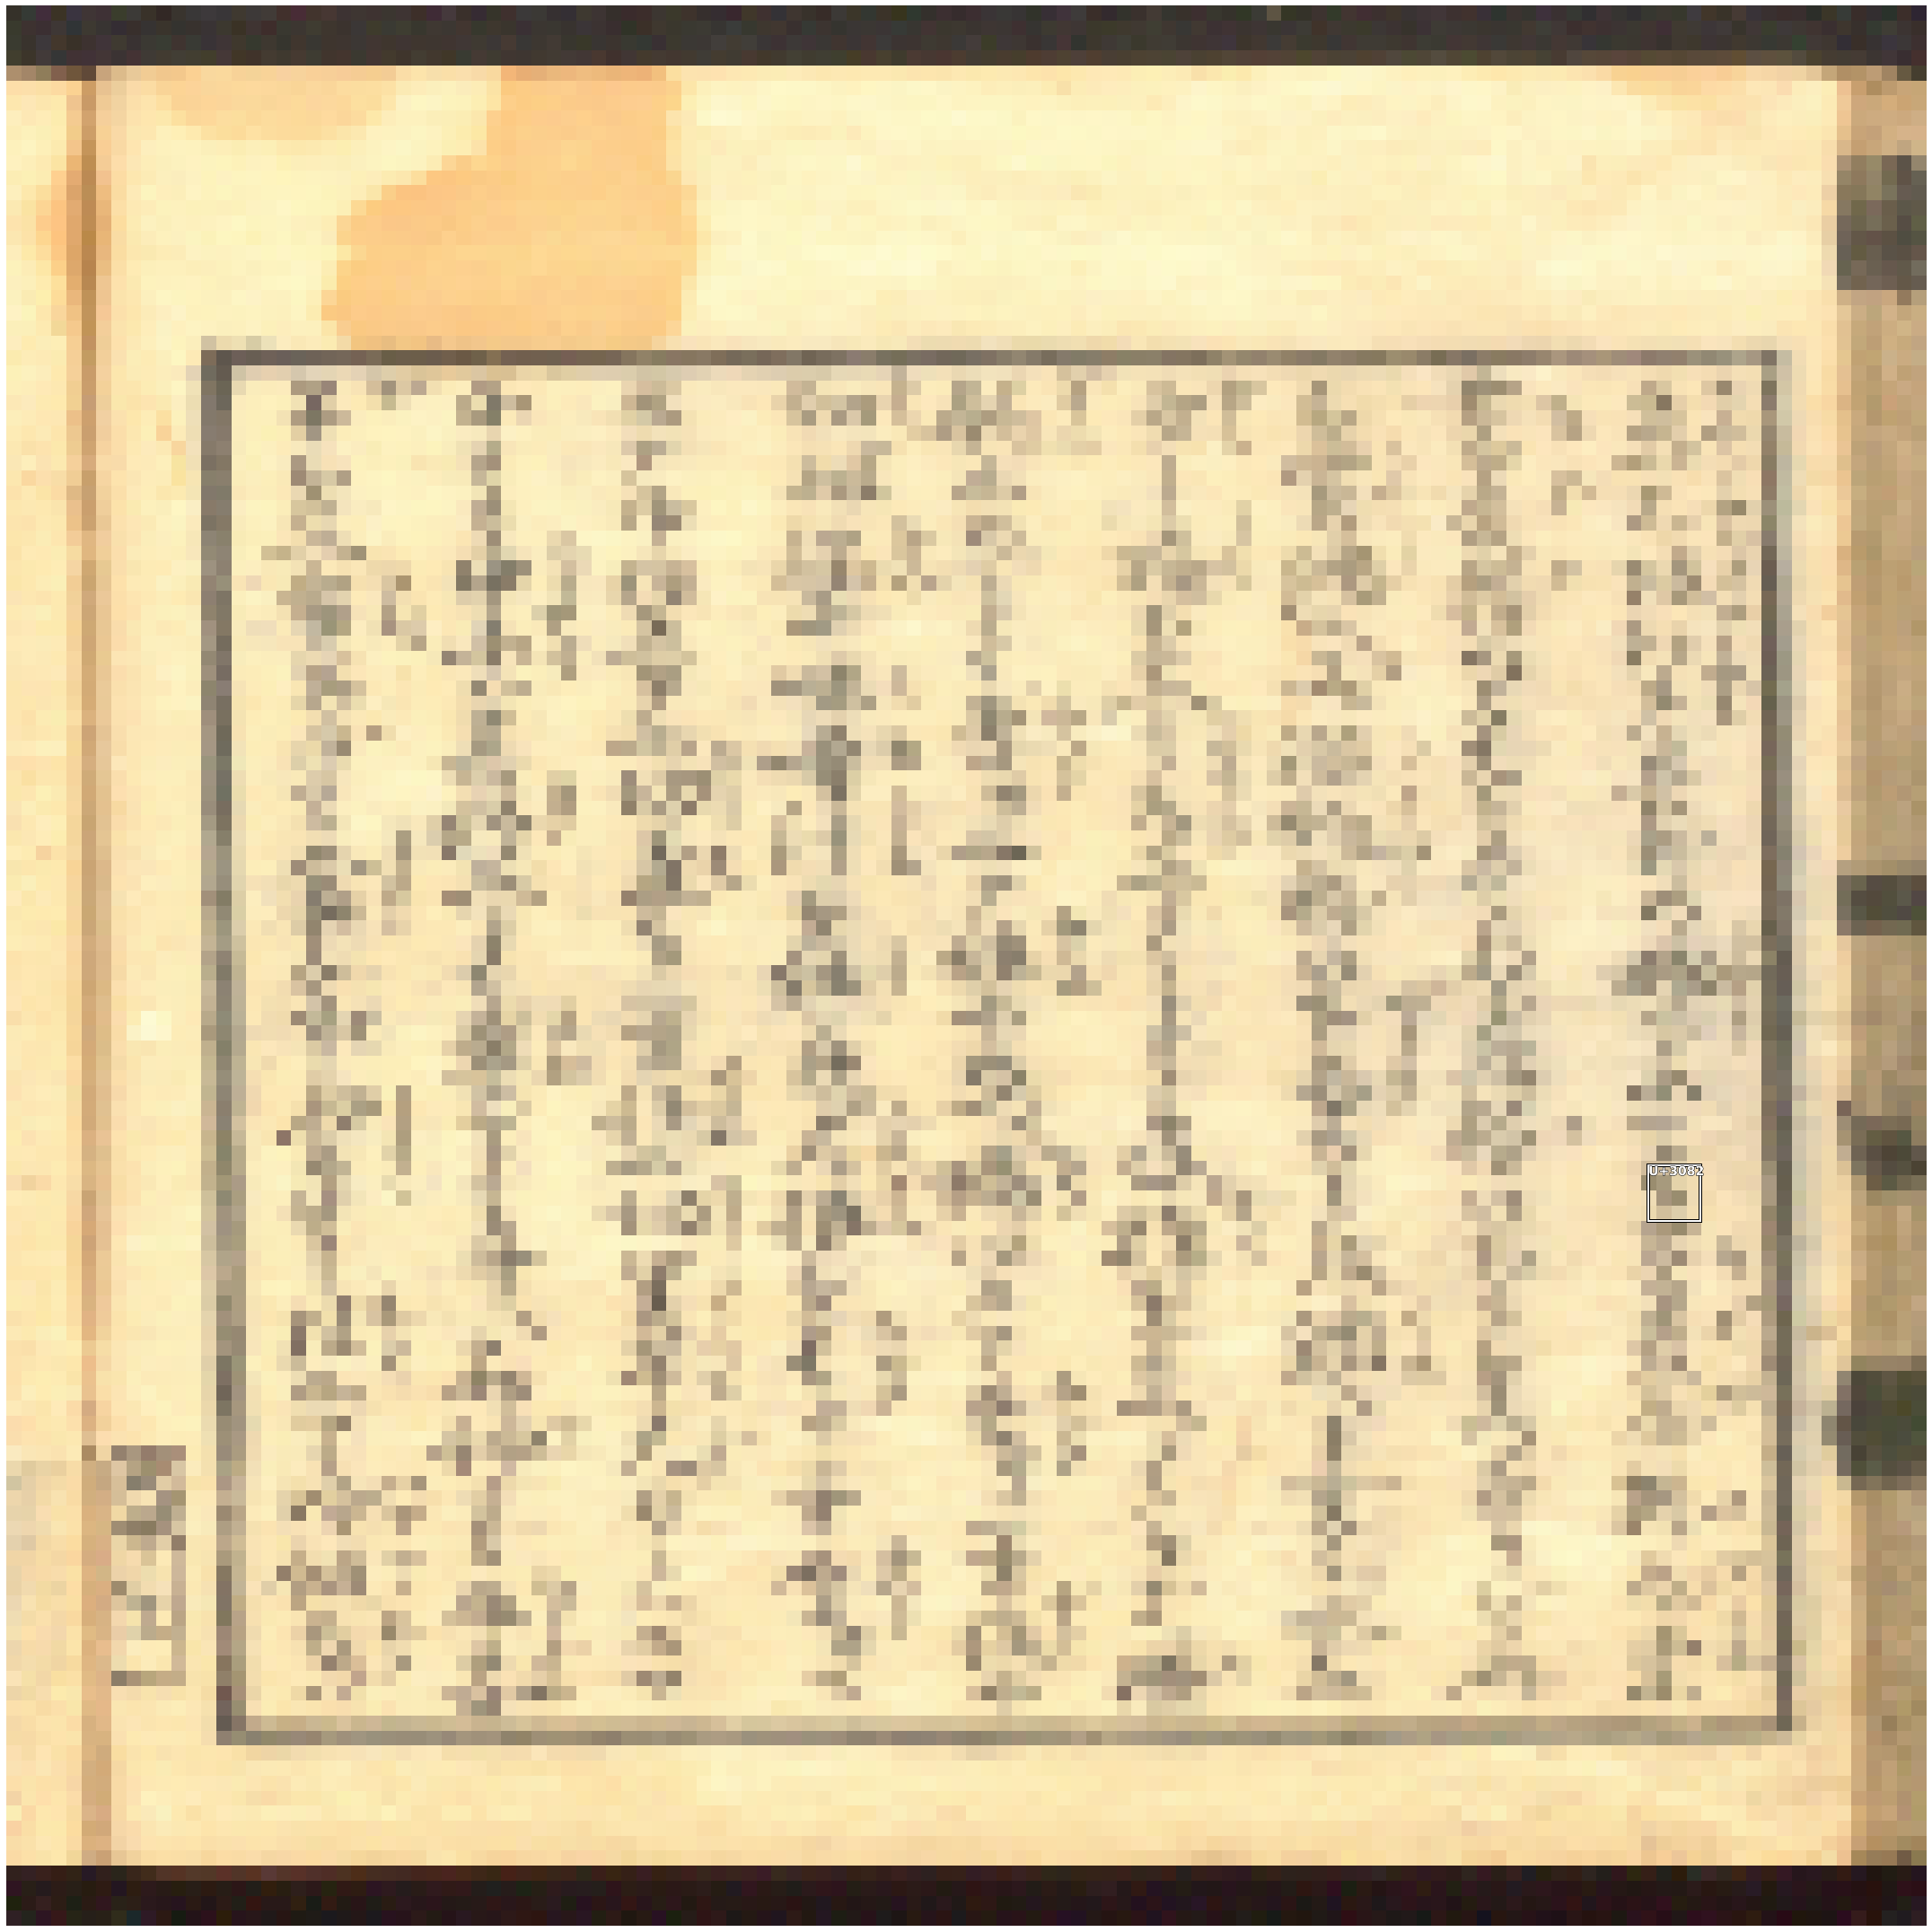

In [40]:
db.show_batch(rows=1, ds_type=DatasetType.Train, figsize=(60,30))

In [181]:
learn

In [ ]:
learn = cnn_learner(db, models.vgg16_bn, metrics=accuracy)

In [182]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


/home/smallrig/Documents/Dev/Projects/DataScience/ComputerVision/KuzushijiRecognizer/kuzushiji_venv/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/home/smallrig/Documents/Dev/Projects/DataScience/ComputerVision/KuzushijiRecognizer/kuzushiji_venv/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


TypeError: __call__() takes 3 positional arguments but 4 were given

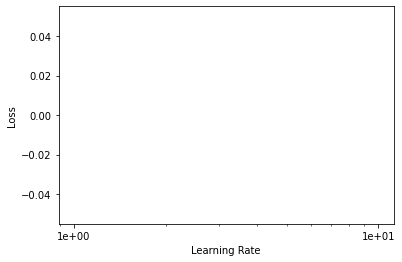